In [11]:
!pwd

/home/spenser/uq/bae-drift-detection-zema-hydraulic


In [2]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from bnn.ensembles_bnn import BAE_Ensemble_Manager
import pickle
import matplotlib.pyplot as plt
import numpy as np
from bnn.multiscaler import MultiScaler
import copy
from bnn.seed import bae_set_seed
from mpl_toolkits.mplot3d import Axes3D
import torch

bae_set_seed(100)

#LOAD DATA
total_sensors = 17
sensor_names = ["ts1","ts2","ts3","ts4","vs1","se","ce","cp"]+["fs1","fs2"]+["ps1","ps2","ps3","ps4","ps5","ps6","eps1"]
pickle_path="pickles/"
data_raw = pickle.load(open(pickle_path+"data_ft_resampled.p", "rb" ) )
x_train, x_test, x_ood, x_test_noise,x_test_drift, = data_raw['x_train'], data_raw['x_test'], data_raw['x_ood'], data_raw['x_test_noise'], data_raw['x_test_drift']
y_train, y_test, y_ood = data_raw['y_train'], data_raw['y_test'], data_raw['y_ood']

def flatten_dimensions(np_array):
    return np_array.reshape(np_array.shape[0],-1)

def nested_list_apply(x_list, apply_func, *args, **kwargs):
    x_list_result = []
    for sensor_data in x_list:
        temp_data = []
        for noise_data in sensor_data:
            temp_data.append(apply_func(noise_data, *args, **kwargs))
        x_list_result.append(temp_data)
    return x_list_result

#normalise data
scaler_class = MultiScaler
scaler = scaler_class(scaler_class=StandardScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_ood = scaler.transform(x_ood)

x_test_noise = nested_list_apply(x_test_noise, scaler.transform)
x_test_drift = nested_list_apply(x_test_drift, scaler.transform)

#reshape to flatten last two dimensions to fit bnn
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)
x_ood = x_ood.reshape(x_ood.shape[0],-1)
x_test_noise = nested_list_apply(x_test_noise, flatten_dimensions)
x_test_drift = nested_list_apply(x_test_drift, flatten_dimensions)

In [35]:
y_train.shape

(518, 5)

In [36]:
x_train.shape

(518, 1020)

In [33]:
import umap
reducer = umap.UMAP(n_components=1,
                    n_neighbors=100,
                    min_dist=0.00001,
                    metric='hellinger',
                    n_jobs=-1,
                    verbose=10,
                    random_state=0)

reducer.fit(y_train)

y_reduced = reducer.transform(y_train)

UMAP(angular_rp_forest=True, metric='hellinger', min_dist=1e-05, n_components=1, n_neighbors=100, random_state=0, verbose=10)
Sun Dec 19 15:04:48 2021 Construct fuzzy simplicial set
Sun Dec 19 15:04:48 2021 Finding Nearest Neighbors
Sun Dec 19 15:04:50 2021 Finished Nearest Neighbor Search
Sun Dec 19 15:04:54 2021 Construct embedding



Sun Dec 19 15:05:03 2021 Finished embedding


In [47]:
from sklearn.decomposition import PCA
def plot_pca_3d(data, y, title):
    pca = PCA(n_components=3)

    comps = pca.fit_transform(data)


    ax = plt.axes(projection='3d')


    if len(y) > 1:
        ax.scatter3D(comps[:,0], comps[:,1], comps[:,2], c = y)
    else:
        ax.scatter3D(comps[:,0], comps[:,1], comps[:,2], c =y)
        
    plt.title(title)

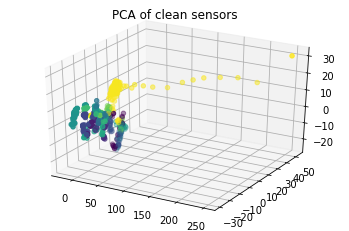

In [48]:
plot_pca_3d(x_train, y_reduced.reshape(518,),
            'PCA of clean sensors')

In [51]:
reducer.fit(y_test)

y_reduced = reducer.transform(y_test)

UMAP(angular_rp_forest=True, metric='hellinger', min_dist=1e-05, n_components=1, n_neighbors=100, random_state=0, verbose=10)
Sun Dec 19 15:10:07 2021 Construct fuzzy simplicial set
Sun Dec 19 15:10:07 2021 Finding Nearest Neighbors
Sun Dec 19 15:10:07 2021 Finished Nearest Neighbor Search
Sun Dec 19 15:10:07 2021 Construct embedding


/home/spenser/anaconda3/envs/prodigy/lib/python3.9/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 2820 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(



Sun Dec 19 15:10:08 2021 Finished embedding


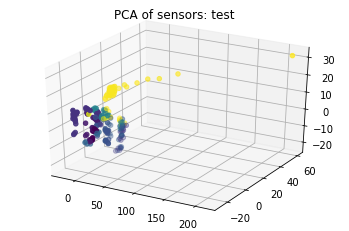

In [53]:
plot_pca_3d(x_test, y_reduced.reshape(len(y_reduced),), 'PCA of sensors: test')

In [49]:
reducer.fit(y_ood)

y_reduced = reducer.transform(y_ood)

UMAP(angular_rp_forest=True, metric='hellinger', min_dist=1e-05, n_components=1, n_neighbors=100, random_state=0, verbose=10)
Sun Dec 19 15:08:51 2021 Construct fuzzy simplicial set
Sun Dec 19 15:08:52 2021 Finding Nearest Neighbors
Sun Dec 19 15:08:52 2021 Finished Nearest Neighbor Search
Sun Dec 19 15:08:52 2021 Construct embedding



Sun Dec 19 15:09:17 2021 Finished embedding


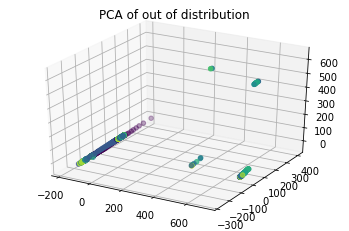

In [50]:
plot_pca_3d(x_ood, y_reduced.reshape(len(y_reduced),), 'PCA of out of distribution')

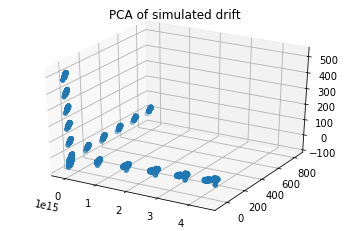

In [26]:
plot_pca_3d(np.array(x_test_drift).reshape(17*6*223, 1020), 'PCA of simulated drift')

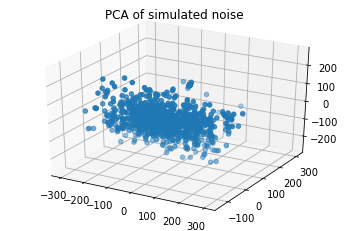

In [28]:
plot_pca_3d(np.array(x_test_noise).reshape(17*6*223, 1020), 'PCA of simulated noise')

#### Autoencoder

In [29]:
#define model
optimiser = "Adam"
num_epoch_mu = 100 #10000 #1000
architecture_mu = [500,250,3,250,500]
architecture_sig_diag_cov=architecture_mu
lr = 0.0008
num_samples = 10
use_cuda = torch.cuda.is_available()

#diag_cov & combined mode
model_name = "diag_cov"
bae_model = BAE_Ensemble_Manager(architecture=architecture_mu, num_samples=num_samples,
                                 num_epoch=num_epoch_mu, learning_rate=lr, bottleneck_layer=2,
                                 task="regression", optimiser=optimiser, mode="diag_cov", use_cuda=use_cuda)

#fit model
bae_model.fit(x_train)


0LOG LOSS:513.8981323242188PW LOSS:-629.072509765625AE LOSS:1142.970703125
1LOG LOSS:511.175537109375PW LOSS:-597.3178100585938AE LOSS:1108.493408203125
2LOG LOSS:499.2814025878906PW LOSS:-566.507080078125AE LOSS:1065.7884521484375
3LOG LOSS:460.6717529296875PW LOSS:-539.4862670898438AE LOSS:1000.1580200195312
4LOG LOSS:400.8559875488281PW LOSS:-515.2266845703125AE LOSS:916.0826416015625
5LOG LOSS:353.7059020996094PW LOSS:-493.0502624511719AE LOSS:846.7561645507812
6LOG LOSS:336.2317810058594PW LOSS:-472.15069580078125AE LOSS:808.3824462890625
7LOG LOSS:326.5872802734375PW LOSS:-452.3572998046875AE LOSS:778.944580078125
8LOG LOSS:317.0276794433594PW LOSS:-433.61224365234375AE LOSS:750.639892578125
9LOG LOSS:307.4552917480469PW LOSS:-415.8570251464844AE LOSS:723.3123168945312
10LOG LOSS:301.4089050292969PW LOSS:-399.10699462890625AE LOSS:700.515869140625
11LOG LOSS:287.3170166015625PW LOSS:-383.66864013671875AE LOSS:670.9856567382812
12LOG LOSS:271.0967102050781PW LOSS:-369.367919921875

#### Predictions

In [6]:
#predictions
result_test = bae_model.predict(x_test, mode=model_name)
result_ood = bae_model.predict(x_ood, mode=model_name)
result_noise = nested_list_apply(x_test_noise, bae_model.predict, mode=model_name)
result_drift = nested_list_apply(x_test_drift, bae_model.predict, mode=model_name)
result_test_mu = bae_model.predict(x_test, mode="mu")
result_ood_mu = bae_model.predict(x_ood, mode="mu")
result_noise_mu = nested_list_apply(x_test_noise, bae_model.predict, mode="mu")
result_drift_mu = nested_list_apply(x_test_drift, bae_model.predict, mode="mu")


/home/spenser/anaconda3/envs/prodigy/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/spenser/anaconda3/envs/prodigy/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/spenser/uq/bae-drift-detection-zema-hydraulic/bnn/autoencoder.py:283: RuntimeWarning: overflow encountered in exp
  return y_pred, np.exp(y_log_noise), loss,latent_z
/home/spenser/anaconda3/envs/prodigy/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


#### Reconstruct signal

In [7]:
#compute more accurate epistemic unc.
def unc_scale(result,seq_len=60,num_sens=17):
    raw_y_pred=result['raw'][0]
    scaled_raw_y_pred = []
    raw_y_cov=result['raw'][1]
    scaled_raw_y_cov = []
    for i in range(len(raw_y_pred)):
        scaled_raw_y_pred.append(scaler.inverse_transform(raw_y_pred[i,:,:].reshape(-1,seq_len,num_sens)))
        scaled_raw_y_cov.append(scaler.inverse_variance((raw_y_cov[i,:,:]**0.5).reshape(-1,seq_len,num_sens)))
    scaled_raw_y_pred= np.array(scaled_raw_y_pred)
    scaled_raw_y_cov= np.array(scaled_raw_y_cov)
    epi_result = scaled_raw_y_pred.std(0)
    alea_result = scaled_raw_y_cov.mean(0)
    total_unc = epi_result+alea_result
    return epi_result, alea_result,total_unc

def alea_unc_scale(result,seq_len=60,num_sens=17):
    temp_res = copy.copy(result['y_cov'][0])
    temp_res= temp_res.reshape(-1,seq_len,num_sens)**0.5
    temp_res = scaler.inverse_variance(temp_res)
    return temp_res

def str_deci(number,num_deci=2):
    return ("{0:."+str(num_deci)+"f}").format(round(number,num_deci))

#plot reconstructed signal
plot_sample_index = 100
plot_sensor_index = 10
severity_index = 2
n_resample = 60

def get_recon_signal(mode="noise",plot_sample_index = 1,plot_sensor_index =12,n_resample = 60,severity_index = 0):
    # feature_sensor_indices = range((n_resample*plot_sensor_index),(n_resample*(1+plot_sensor_index)))
    if mode == "noise":
        recon_sig=scaler.inverse_transform(result_noise[plot_sensor_index][severity_index]['y_pred'][0].reshape(-1,n_resample,total_sensors))
        recon_sig_epi_unc,recon_sig_alea_unc,recon_sig_total_unc=unc_scale(result_noise[plot_sensor_index][severity_index])
        ori_sig = scaler.inverse_transform(x_test_noise[plot_sensor_index][severity_index].reshape(-1,n_resample,total_sensors))
    elif mode=="drift":
        recon_sig=scaler.inverse_transform(result_drift[plot_sensor_index][severity_index]['y_pred'][0].reshape(-1,n_resample,total_sensors))
        recon_sig_epi_unc,recon_sig_alea_unc,recon_sig_total_unc=unc_scale(result_drift[plot_sensor_index][severity_index])
        ori_sig = scaler.inverse_transform(x_test_drift[plot_sensor_index][severity_index].reshape(-1,n_resample,total_sensors))
    else:
        recon_sig=scaler.inverse_transform(result_ood['y_pred'][0].reshape(-1,n_resample,total_sensors))
        recon_sig_epi_unc,recon_sig_alea_unc,recon_sig_total_unc=unc_scale(result_ood)
        ori_sig = scaler.inverse_transform(x_ood.reshape(-1,n_resample,total_sensors))

    recon_loss = ((recon_sig - ori_sig)**2)

    plot_recon_sig = recon_sig[plot_sample_index,:,plot_sensor_index]
    plot_ori_sig = ori_sig[plot_sample_index,:,plot_sensor_index]
    plot_recon_loss = recon_loss[plot_sample_index,:,plot_sensor_index]
    epi_unc =recon_sig_epi_unc[plot_sample_index,:,plot_sensor_index]
    alea_unc =recon_sig_alea_unc[plot_sample_index,:,plot_sensor_index]
    total_unc = recon_sig_total_unc[plot_sample_index,:,plot_sensor_index]

    return {"recon_sig":plot_recon_sig,
            "ori_sig":plot_ori_sig,
            "recon_loss":plot_recon_loss,
           "epi_unc":epi_unc,
           "alea_unc":alea_unc,
           "total_unc":total_unc
            }

#PLOT RECONSTRUCTED SIGNAL
recon_signal_test = get_recon_signal(plot_sample_index = plot_sample_index,plot_sensor_index =plot_sensor_index,severity_index=0)
recon_signal_noise = get_recon_signal(mode="noise",plot_sample_index = plot_sample_index,plot_sensor_index =plot_sensor_index,severity_index=severity_index)
recon_signal_ood = get_recon_signal(mode="ood",plot_sample_index = plot_sample_index,plot_sensor_index =plot_sensor_index)
recon_signal_drift = get_recon_signal(mode="drift",plot_sample_index = plot_sample_index,plot_sensor_index =plot_sensor_index,severity_index=severity_index)


/home/spenser/anaconda3/envs/prodigy/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/spenser/anaconda3/envs/prodigy/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/spenser/anaconda3/envs/prodigy/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarn

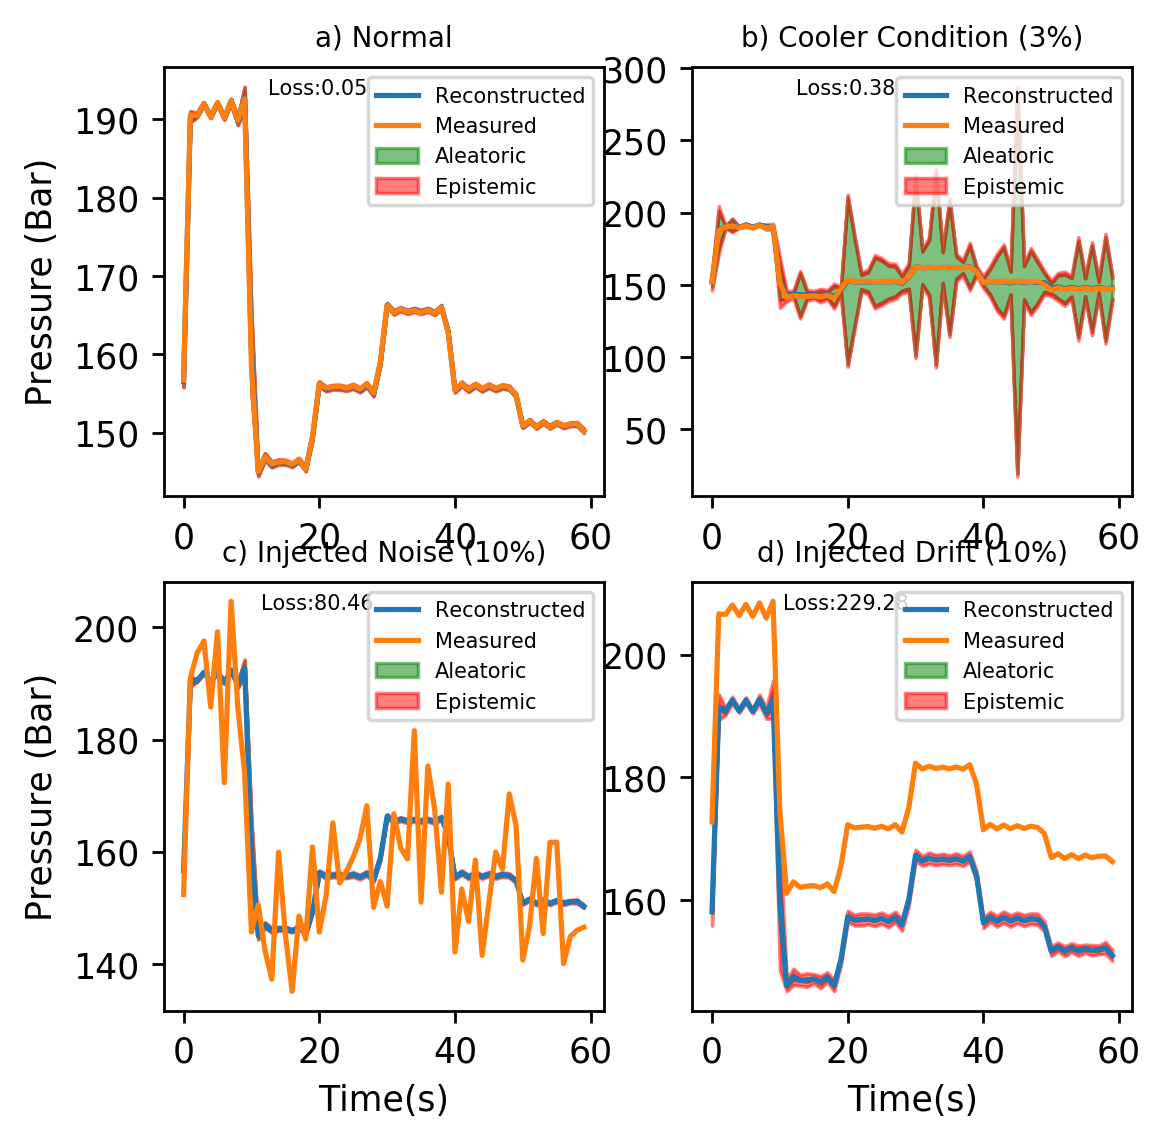

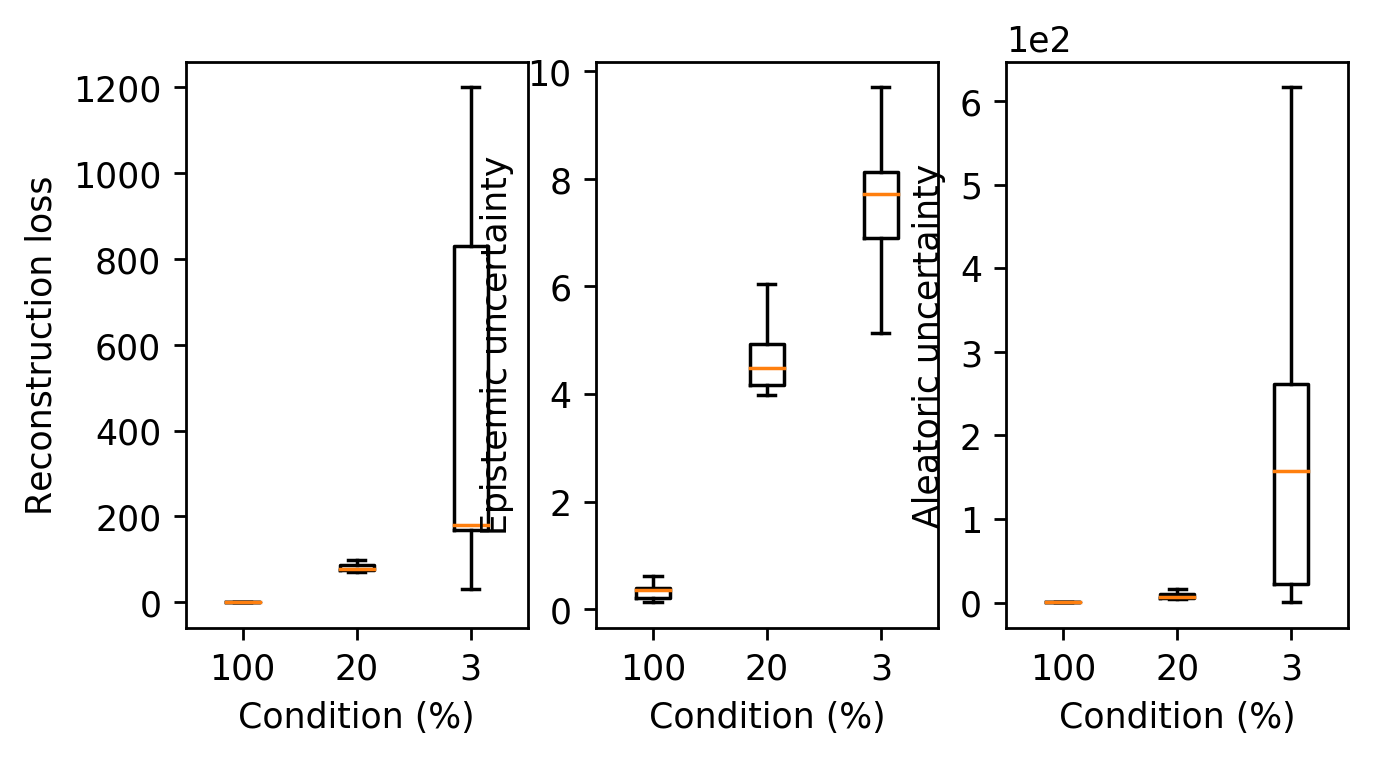

<Figure size 432x288 with 0 Axes>

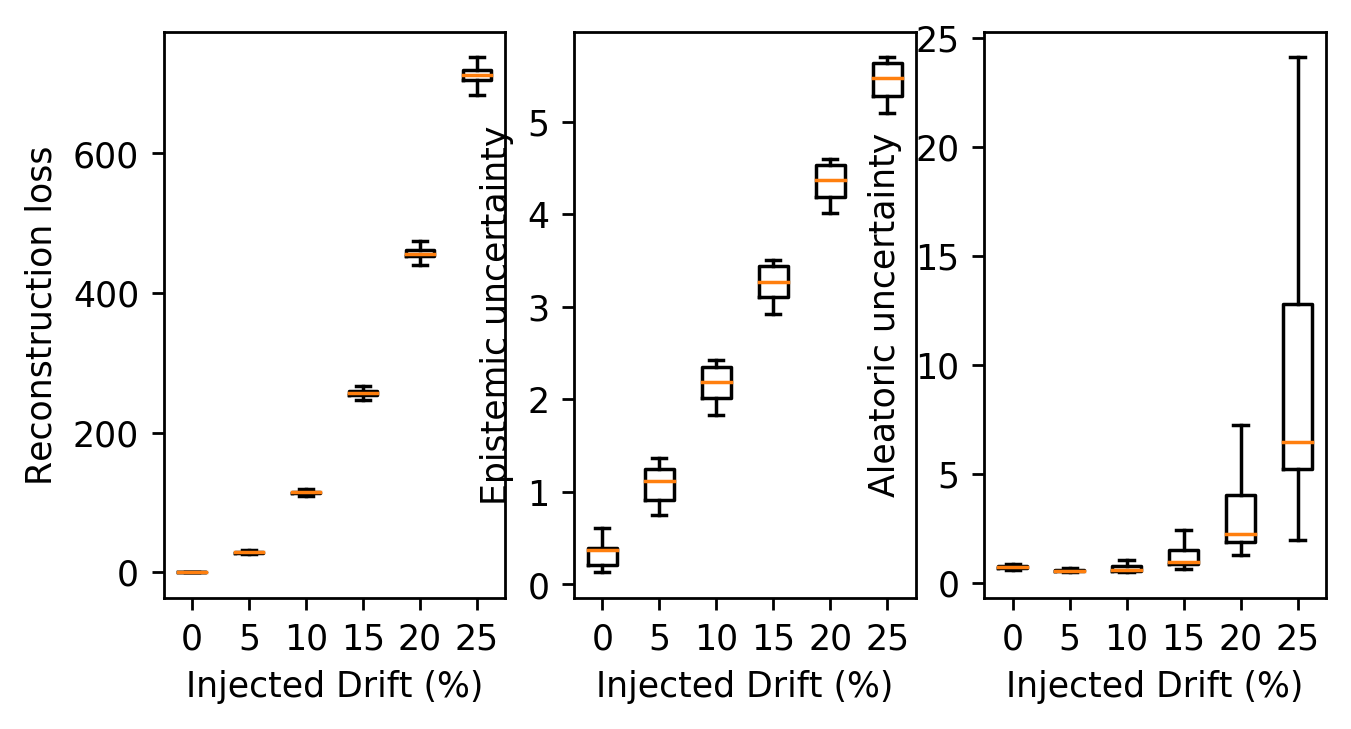

<Figure size 432x288 with 0 Axes>

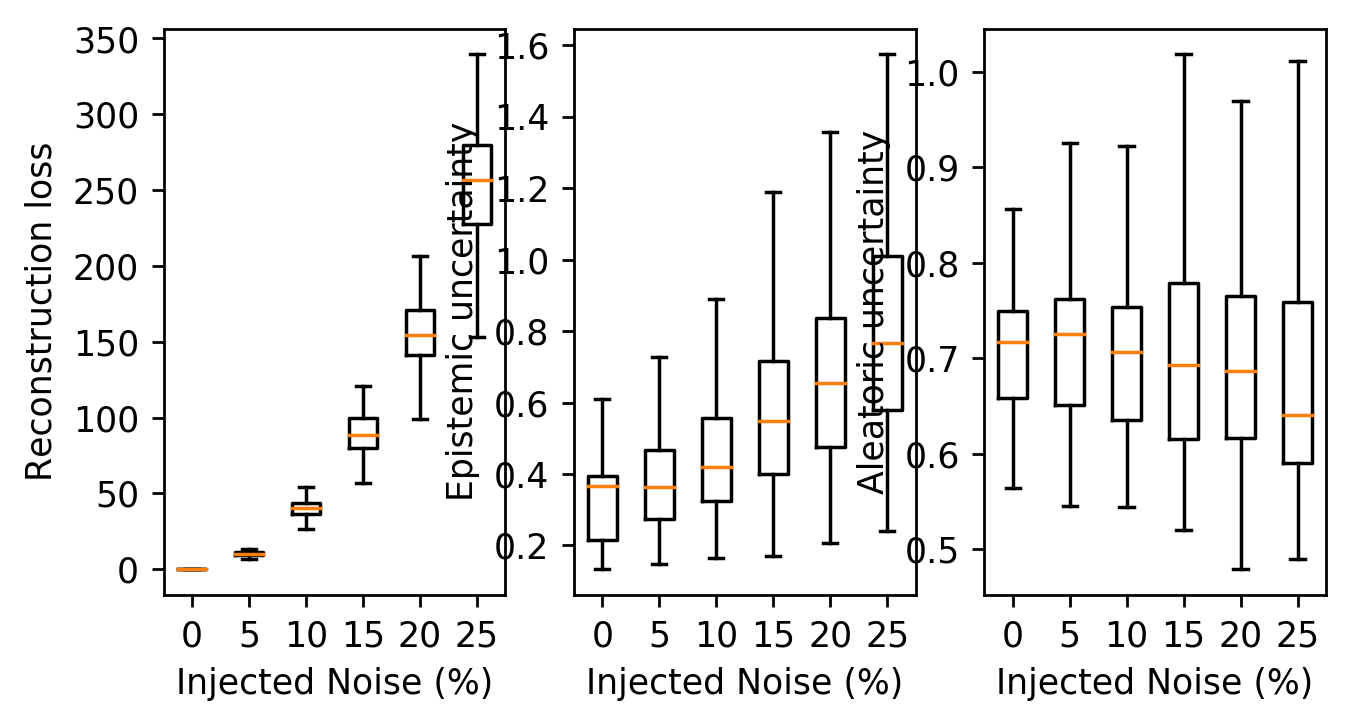

Text(0.06, 0.81, '$\\times 10^{3}$')

<Figure size 432x288 with 0 Axes>

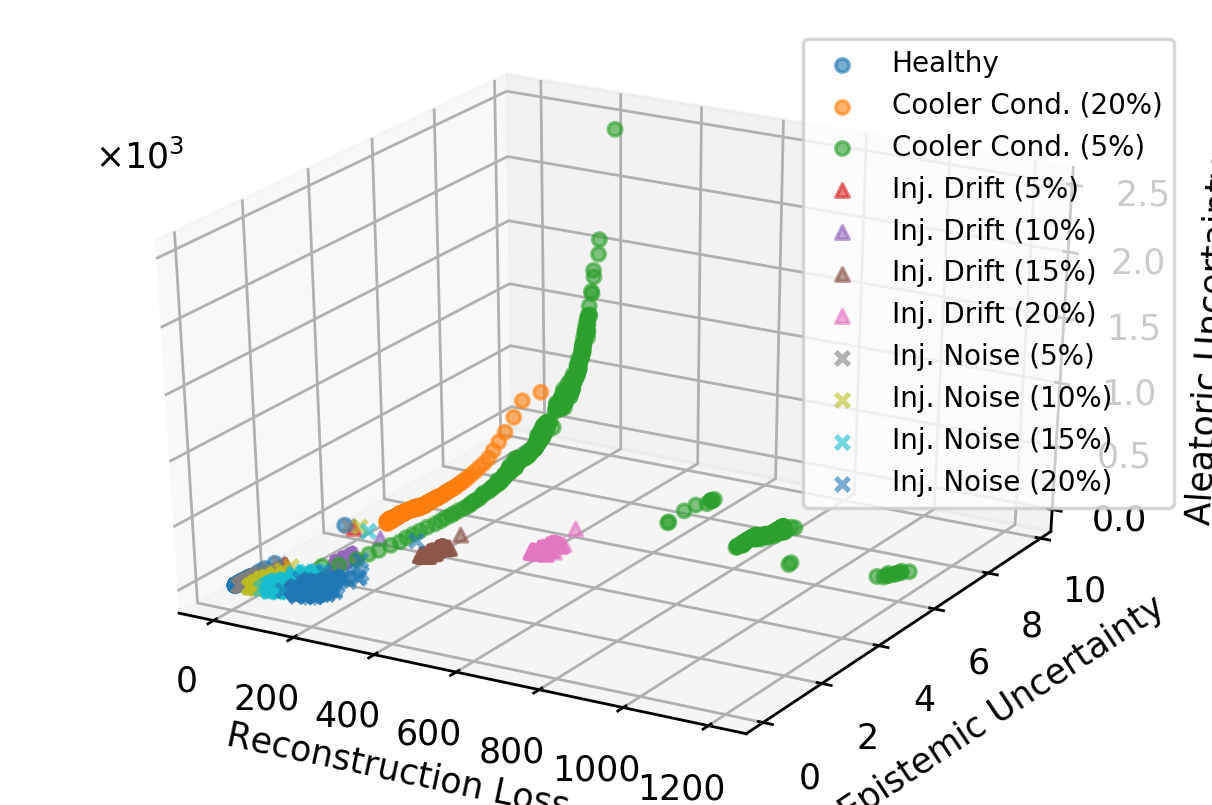

In [10]:



fig, axes = plt.subplots(2,2, figsize=(5,5),dpi=250)
axes = axes.reshape(-1)
plot_titles = ["a) Normal", "b) Cooler Condition (3%)", "c) Injected Noise (10%)","d) Injected Drift (10%)"]
ax_ids = np.arange(len(axes))
for ax_id,ax,recon_signal,plot_title in zip(ax_ids,axes,[recon_signal_test,recon_signal_ood,recon_signal_noise,recon_signal_drift],plot_titles):
    plot_recon_sig,plot_ori_sig,recon_loss,epi_unc,alea_unc,total_unc = recon_signal['recon_sig'],recon_signal['ori_sig'],recon_signal['recon_loss'],recon_signal['epi_unc'],recon_signal['alea_unc'],recon_signal['total_unc']
    ax.plot(plot_recon_sig)
    ax.plot(plot_ori_sig)
    ax.fill_between(range(n_resample), (plot_recon_sig+alea_unc), (plot_recon_sig-alea_unc),alpha=0.5,color='g')
    ax.fill_between(range(n_resample), (plot_recon_sig+epi_unc+alea_unc), (plot_recon_sig+alea_unc),alpha=0.5,color='r')
    ax.fill_between(range(n_resample), (plot_recon_sig-alea_unc), (plot_recon_sig-epi_unc-alea_unc),alpha=0.5,color='r')

    recon_loss_mean,epi_unc_mean, alea_unc_mean, total_unc_mean = recon_loss.mean(),epi_unc.mean(),alea_unc.mean(),epi_unc.mean()+alea_unc.mean()

    ax.legend(["Reconstructed","Measured","Aleatoric","Epistemic"],prop={'size': 6})
    if ax_id == 2 or ax_id == 3:
        ax.set_xlabel("Time(s)")
    if ax_id == 0 or ax_id == 2:
        ax.set_ylabel("Pressure (Bar)")
    ax.set_title(plot_title,fontsize=8)
    ax.text(0.35, 0.95,'Loss:'+str_deci(recon_loss_mean,2), ha='center', va='center', transform=ax.transAxes,fontsize=6)

#Reconstruction loss
def vanilla_recon_loss(x_test,result_mu):
    return ((result_mu['y_pred'][0]-x_test)**2).mean(1)

def get_nested_recon_loss(result,x_test):
    return [vanilla_recon_loss(x_test[id_],result[id_]) for id_, noise_data in enumerate(result)]

recon_test = vanilla_recon_loss(x_test,result_test_mu)
recon_ood = vanilla_recon_loss(x_ood,result_ood_mu)
recon_noise = []
recon_drift = []

for sensor_id,sensor_data in enumerate(result_noise_mu):
    temp_data_noise = []
    temp_data_drift = []
    for noise_id,noise_data in enumerate(sensor_data):
        temp_data_noise.append(vanilla_recon_loss(x_test_noise[sensor_id][noise_id],sensor_data[noise_id]))
        temp_data_drift.append(vanilla_recon_loss(x_test_drift[sensor_id][noise_id],sensor_data[noise_id]))
    recon_noise.append(temp_data_noise)
    recon_drift.append(temp_data_drift)

def mean_unc(result_data,seq_len=60,num_sens=17):
    epi,alea,total = unc_scale(result_data,seq_len=60,num_sens=17)
    epi = epi.reshape(-1,seq_len*num_sens)
    alea = alea.reshape(-1,seq_len*num_sens)
    total = total.reshape(-1,seq_len*num_sens)

    return epi.mean(1),alea.mean(1),total.mean(1)

epi_test,alea_test,_ = mean_unc(result_test)
epi_ood,alea_ood,_ = mean_unc(result_ood)
unc_result_noise = nested_list_apply(result_noise,mean_unc)
unc_result_drift = nested_list_apply(result_drift,mean_unc)

#aleatoric uncertainty
def mean_alea_unc(batch_cov_mat,index_alea=0):
    """
    For batch covariance matrix, extracts the diagonal and compute
    the mean by the last dimension (expected as the number of features)
    """
    batch_cov_mat_y_cov = batch_cov_mat['y_cov'][index_alea]
    if len(batch_cov_mat_y_cov.shape) ==3:
        #extract diagonal of cov. matrix
        iii,jjj = np.diag_indices(batch_cov_mat_y_cov.shape[-1])
        alea_temp = batch_cov_mat_y_cov[...,iii,jjj]
    else:
        alea_temp = batch_cov_mat_y_cov
    alea_temp = (alea_temp**0.5).mean(-1)
    return alea_temp

#argwhere to separate by severity of condition
index_target = 0
columns_ood = np.unique(y_ood[:,index_target])
index_ood = []

for unique_condition in columns_ood:
    index_ood += [np.argwhere(y_ood[:,index_target] == unique_condition).reshape(-1)]

#PLOTS FOR VARYING CONDITION
# plot - recon loss
show_outliers = False
recon_loss_plot =[]
recon_loss_plot += [recon_test]
for i in index_ood:
    recon_loss_plot += [recon_ood[i]]

# plot - epistemic uncertainty
epi_unc_plot =[]
epi_unc_plot += [epi_test]
for i in index_ood:
    epi_unc_plot += [epi_ood[i]]

#plot - aleatoric uncertainty (diagonal cov)
alea_unc_plot =[]
alea_unc_plot += [alea_test]
for i in index_ood:
    alea_unc_plot += [alea_ood[i]]

figsize = (6,3)
dpi = 250
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=figsize,dpi=dpi)

x_tick_labels_eff = ('100', '20', '3')
ax1.boxplot(recon_loss_plot,showfliers=show_outliers)
ax1.set_xticklabels( x_tick_labels_eff)
ax1.set_ylabel("Reconstruction loss")
ax1.set_xlabel("Condition (%)")

ax2.boxplot(epi_unc_plot,showfliers=show_outliers)
ax2.set_xticklabels(x_tick_labels_eff)
ax2.set_ylabel("Epistemic uncertainty")
ax2.set_xlabel("Condition (%)")

ax3.boxplot(alea_unc_plot,showfliers=show_outliers)
ax3.set_xticklabels(x_tick_labels_eff)
ax3.set_ylabel("Aleatoric uncertainty")
ax3.set_xlabel("Condition (%)")

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()
plt.tight_layout()

#plot noise level
np_unc_result_noise = np.array(unc_result_noise)
np_unc_result_drift = np.array(unc_result_drift)


#Plot single row for drifts
#set plot sensor id here to show the sensitivity of metrics toward injected drifts
figsize = (6,3)
dpi = 250
fig, axes = plt.subplots(1,3,figsize=figsize,dpi=dpi)
sensor_id = 10
# x_tick_labels_eff = ('0', '1', '2', '3', '4', '5')
x_tick_labels_eff = ('0', '5', '10', '15', '20', '25')
axes[0].boxplot(recon_drift[sensor_id],showfliers=show_outliers)
axes[0].set_xticklabels(x_tick_labels_eff)
axes[0].set_ylabel("Reconstruction loss")
axes[0].set_xlabel("Injected Drift (%)")

axes[1].boxplot(np_unc_result_drift[sensor_id,:,0,:].tolist(),showfliers=show_outliers)
axes[1].set_xticklabels(x_tick_labels_eff)
axes[1].set_ylabel("Epistemic uncertainty")
axes[1].set_xlabel("Injected Drift (%)")

axes[2].boxplot(np_unc_result_drift[sensor_id,:,1,:].tolist(),showfliers=show_outliers)
axes[2].set_xticklabels(x_tick_labels_eff)
axes[2].set_ylabel("Aleatoric uncertainty")
axes[2].set_xlabel("Injected Drift (%)")
plt.show()
plt.tight_layout()

#Plot single row for noise
#set plot sensor id here to show the sensitivity of metrics toward injected noise

fig, axes = plt.subplots(1,3,figsize=figsize,dpi=dpi)
sensor_id = 10
x_tick_labels_eff = ('0', '5', '10', '15', '20', '25')
axes[0].boxplot(recon_noise[sensor_id],showfliers=show_outliers)
axes[0].set_xticklabels(x_tick_labels_eff)
axes[0].set_ylabel("Reconstruction loss")
axes[0].set_xlabel("Injected Noise (%)")

axes[1].boxplot(np_unc_result_noise[sensor_id,:,0,:].tolist(),showfliers=show_outliers)
axes[1].set_xticklabels(x_tick_labels_eff)
axes[1].set_ylabel("Epistemic uncertainty")
axes[1].set_xlabel("Injected Noise (%)")

axes[2].boxplot(np_unc_result_noise[sensor_id,:,1,:].tolist(),showfliers=show_outliers)
axes[2].set_xticklabels(x_tick_labels_eff)
axes[2].set_ylabel("Aleatoric uncertainty")
axes[2].set_xlabel("Injected Noise (%)")
plt.show()
plt.tight_layout()

#plot cov. matrix
if model_name == "full_cov":
    plot_sample_index = 20
    y_cov_mu_test = result_test['y_cov'][0][0]
    y_cov_mu_ood_0 = result_ood['y_cov'][0][index_ood[0][plot_sample_index]]
    y_cov_mu_ood_1 = result_ood['y_cov'][0][index_ood[1][plot_sample_index]]

    y_cov_list = [y_cov_mu_test,y_cov_mu_ood_0,y_cov_mu_ood_1]
    plot_name_list = ["y_cov_mu_test","y_cov_mu_ood_0","y_cov_mu_ood_1"]

#plot for increasing noise
if model_name == "full_cov":
    plot_sample_index = 0

    y_cov_mu_noise = [noise_data['y_cov'][0][0] for noise_data in result_noise]
    y_cov_mu_drift = [drift_data['y_cov'][0][0] for drift_data in result_drift]

    plot_name_noise_list = [str(i)+"_Noise" for i in range(len(y_cov_mu_noise))]
    plot_name_drift_list = [str(i)+"_Drift" for i in range(len(y_cov_mu_drift))]


    matrix_list = [y_cov_mu_test,y_cov_mu_ood_1,y_cov_mu_noise[-1],y_cov_mu_drift[-1]]
    vmin, vmax = np.array(matrix_list).min(),np.array(matrix_list).max()
    num_plots = len(matrix_list)

    fig, axes = plt.subplots(2,2)
    axes = axes.reshape(-1)
    sup_titles = ["a) Healthy condition","b) Near breakdown","c) Injected Noise (5%)","d) Injected Drift (5 bar)"]
    for id_,cov_mat in enumerate(matrix_list):
        im = axes[id_].imshow(matrix_list[id_],cmap='viridis')
        axes[id_].set_title(sup_titles[id_])
        plt.colorbar(im, ax=axes[id_])

#plot colored samples
result_plot = result_ood
num_colored_samples = 30
index_sample = np.arange(0,num_colored_samples)

epi_sample = np.transpose(result_plot['y_pred'][1][index_sample])
recon_sample = np.transpose((result_plot['y_pred'][0][index_sample]-x_test_noise[1][0][index_sample])**1)
recon_sample = np.abs(recon_sample)
alea_sample = np.transpose(result_plot['y_cov'][0][index_sample])

num_sensors = 17
epi_sample_reshuffled = np.zeros((num_sensors,num_colored_samples))
recon_sample_reshuffled = np.zeros((num_sensors,num_colored_samples))
alea_sample_reshuffled = np.zeros((num_sensors,num_colored_samples))

feature_sensor_index =np.arange(60)*17
feature_sensor_index_list = []

#create index
for i in range(17):
    start_index = i*60
    end_index = (i+1)*60
    feature_sensor_index_list.append(copy.copy(feature_sensor_index)+i)
    epi_sample_reshuffled[i,:]=epi_sample[feature_sensor_index_list[-1],:].mean(0)
    recon_sample_reshuffled[i,:]=recon_sample[feature_sensor_index_list[-1],:].mean(0)
    alea_sample_reshuffled[i,:]=alea_sample[feature_sensor_index_list[-1],:].mean(0)

#3D Coordinate plot
fig = plt.figure(dpi=250)
ax = fig.add_subplot(111, projection='3d')

marker_alpha = 0.6
marker_size = 15
z_scaler = 1e-3
for plot_ood_index in [0,1,2]:
    ax.scatter(recon_loss_plot[plot_ood_index], epi_unc_plot[plot_ood_index], alea_unc_plot[plot_ood_index]*z_scaler, alpha=marker_alpha, s=marker_size)

legend_list = ["Healthy", "Cooler Cond. (20%)", "Cooler Cond. (5%)"]

for plot_drift_level_index in [1,2,3,4]:
    ax.scatter(recon_drift[sensor_id][plot_drift_level_index], np_unc_result_drift[sensor_id,plot_drift_level_index,0,:], np_unc_result_drift[sensor_id,plot_drift_level_index,1,:]*z_scaler, marker='^', alpha=marker_alpha,s=marker_size)
    legend_list.append("Inj. Drift ("+str(x_tick_labels_eff[plot_drift_level_index])+"%)")

for plot_noise_level_index in [1,2,3,4]:
    ax.scatter(recon_noise[sensor_id][plot_noise_level_index], np_unc_result_noise[sensor_id,plot_noise_level_index,0,:], np_unc_result_noise[sensor_id,plot_noise_level_index,1,:]*z_scaler, marker='x', alpha=marker_alpha,s=marker_size)
    legend_list.append("Inj. Noise ("+str(x_tick_labels_eff[plot_noise_level_index])+"%)")

ax.set_xlabel('Reconstruction Loss')
ax.set_ylabel('Epistemic Uncertainty')
ax.set_zlabel('Aleatoric Uncertainty')

ax.legend(legend_list, prop={'size': 8})
ax.text2D(0.06, 0.81, '$\\times 10^{3}$', transform=ax.transAxes)